[585.  617.5 650.  682.5 715. ] nm
[633.75  641.875 650.    658.125 666.25 ] nm


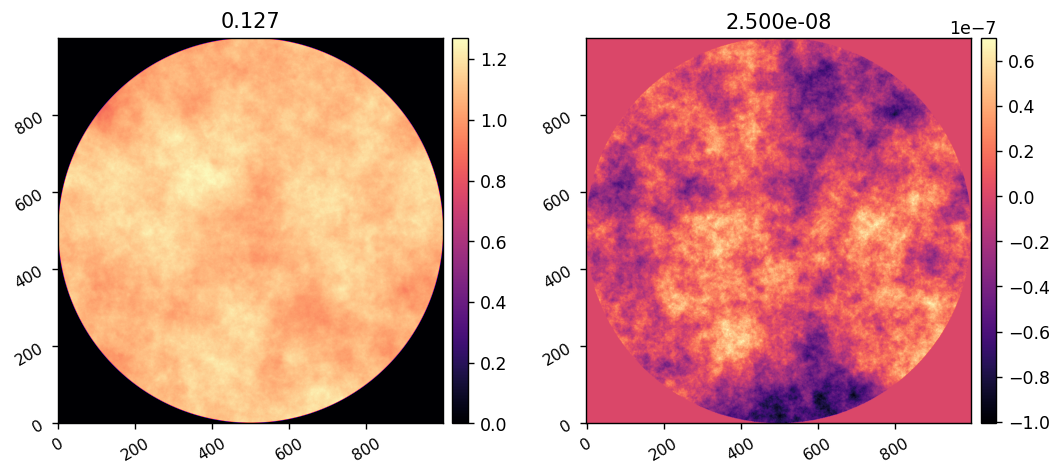

array(2.5e-08)

In [1]:

import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Circle
import copy
from importlib import reload

from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

import ray

import scoobpsf
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.compact_scoob as scoob
import scoobpsf.parascoob as parascoob
import scoobpsf.dm as dm

import lina

N_llowfsc_waves = 5
bw = 0.2
wavelength_c = 650*u.nm
llowfsc_waves = np.linspace(wavelength_c*(1 - bw/2), wavelength_c*(1 + bw/2), N_llowfsc_waves)
print(llowfsc_waves)

N_coro_waves = 5
bw = 0.05
wavelength_c = 650*u.nm
coro_waves = np.linspace(wavelength_c*(1 - bw/2), wavelength_c*(1 + bw/2), N_coro_waves)
print(coro_waves)

reload(utils)
npix = 1000
WFE, mask = utils.generate_wfe(diam=10*u.mm,
                                npix=npix, oversample=1,
                                wavelength=wavelength_c,
                                opd_index=2.75, amp_index=3,
                                opd_rms=25*u.nm, amp_rms=0.05,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*wavelength_c.to_value(u.m)/2/np.pi
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')
lina.utils.rms(wfe_opd[mask])


In [2]:
ray_scoob = ray.remote(scoob.CORO)

llowfsc_actors = []
for i in range(N_llowfsc_waves):
    llowfsc_actors.append(ray_scoob.options(num_cpus=4, num_gpus=1/10).remote(wavelength=llowfsc_waves[i]))

coro_actors = []
for i in range(N_coro_waves):
    coro_actors.append(ray_scoob.options(num_cpus=4, num_gpus=1/10).remote(wavelength=coro_waves[i]))


2024-05-17 16:57:13,381	INFO worker.py:1636 -- Started a local Ray instance.


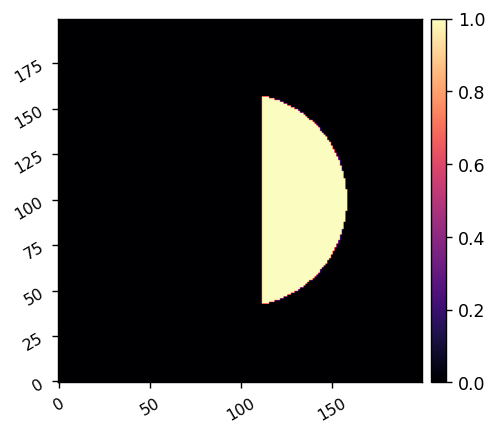

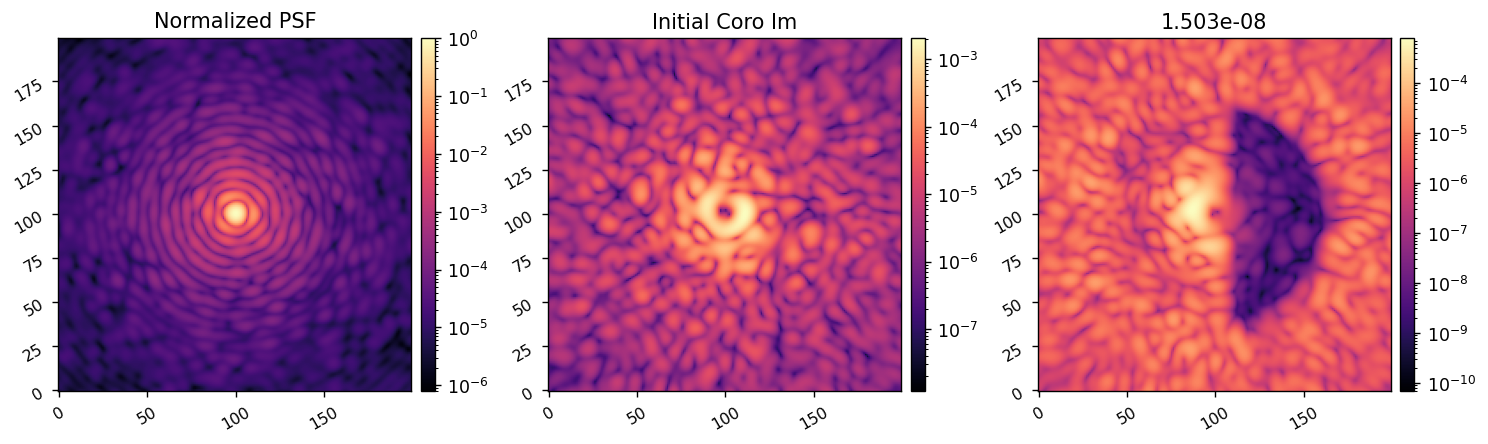

In [62]:
reload(parascoob)
coro_model = parascoob.ParallelizedScoob(actors=coro_actors)
coro_model.set_actor_attr('WFE', WFE)
coro_model.zero_dm()
coro_model.set_actor_attr('use_fpm', False)
coro_model.set_actor_attr('Imax_ref', xp.max(coro_model.snap()))
ref_psf = coro_model.snap()
coro_model.set_actor_attr('use_fpm', True)
ref_coro_im = coro_model.snap()

dark_hole_command = xp.array(fits.getdata('dark_hole_command.fits'))
coro_model.dm_ref = dark_hole_command
coro_model.reset_dm()
dark_coro_im = coro_model.snap()

control_mask = lina.utils.create_annular_focal_plane_mask(coro_model, 2, 10, 2, plot=True)
mean_contrast = xp.mean(dark_coro_im[control_mask])

imshow3(ref_psf, ref_coro_im, dark_coro_im, 'Normalized PSF', 'Initial Coro Im', f'{mean_contrast:.3e}', lognorm=True)

In [63]:
reload(parascoob)
model = parascoob.ParallelizedScoob(actors=llowfsc_actors)
model.set_actor_attr('WFE', WFE)
model.set_actor_attr('use_fpm', True)
model.dm_ref = dark_hole_command
model.reset_dm()
model.use_llowfsc()


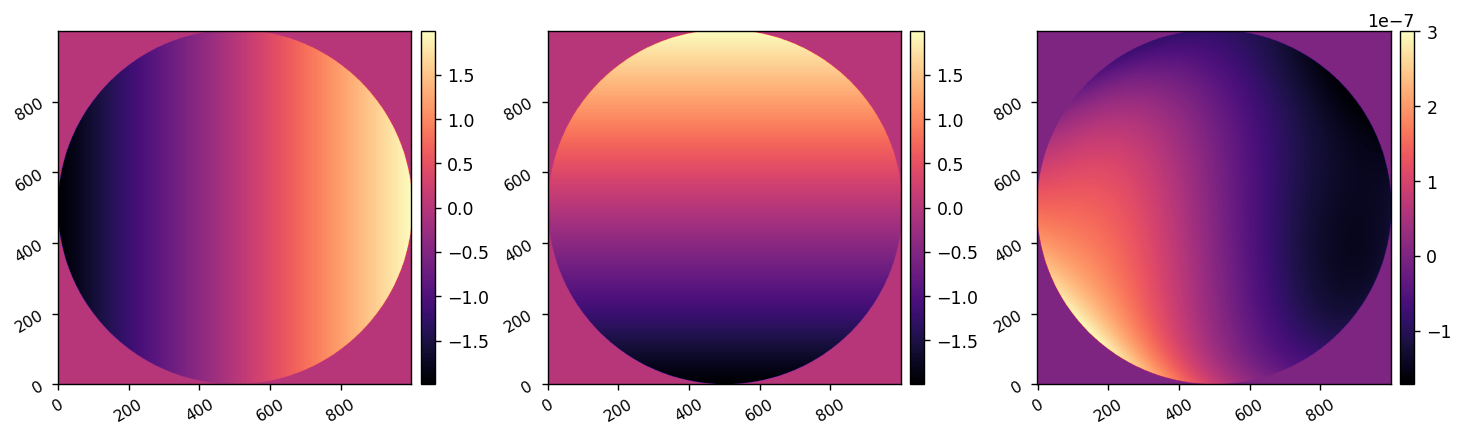

In [51]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

import lina
from lina import psds
reload(psds)

wfe_modes_rms = np.array([100e-9]*2 + [10e-9]*3 + [5e-9]*4 + [1e-9]*16)
N_wfe_modes = len(wfe_modes_rms)
wfe_modes = lina.utils.create_zernike_modes(model.getattr('APERTURE'), nmodes=wfe_time_series.shape[0]-1, remove_modes=1)
wfe_time_series = xp.zeros((N_wfe_modes+1, len(times)))

fmax = 1000*u.Hz
freqs, delF, times = psds.generate_freqs(Nf=2**20+1, f_max=fmax)
wfe_time_series[0] = xp.array(times.to_value(u.s))

slope = 4
for i in range(N_wfe_modes):
    if i<2: 
        f_knee = 0.3*u.Hz
    else: 
        f_knee = 0.1*u.Hz
    psd = psds.kneePSD(freqs, 1, f_knee, slope)
    coeff = psds.generate_time_series(psd, fmax, rms=1, seed=12345+i)
    wfe_time_series[i+1] = wfe_modes_rms[i] * xp.array(coeff)

start_i = 1000
lo_wfe = wfe_modes.reshape(N_wfe_modes, npix**2).T.dot(wfe_time_series[1:,i]).reshape(npix,npix)
imshow3(wfe_modes[0], wfe_modes[1], lo_wfe)

In [53]:
N_samples = 2000
sampling = 2
time_series = xp.zeros((N_wfe_modes+1, N_samples))
for i in range(N_samples):
    time_series[:,i] = xp.array(wfe_time_series[:,start_i + i*sampling])
print(f'{time_series[0][1]-time_series[0][0]:.4e}s')

1.0000e-03s


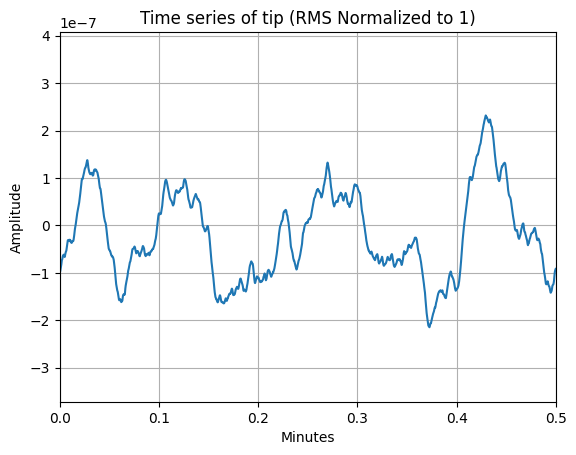

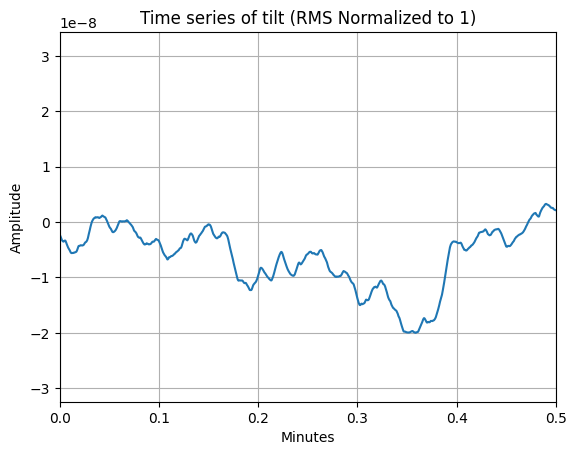

In [58]:
plt.plot(ensure_np_array(wfe_time_series[0])/60, ensure_np_array(wfe_time_series[1]))
plt.title('Time series of tip (RMS Normalized to 1)')
plt.ylabel('Amplitude')
plt.grid()
plt.xlim([0,0.5])
plt.xlabel('Minutes')
plt.show()

plt.plot(ensure_np_array(wfe_time_series[0])/60, ensure_np_array(wfe_time_series[3]))
plt.title('Time series of tilt (RMS Normalized to 1)')
plt.ylabel('Amplitude')
plt.grid()
plt.xlim([0,0.5])
plt.xlabel('Minutes')
plt.show()

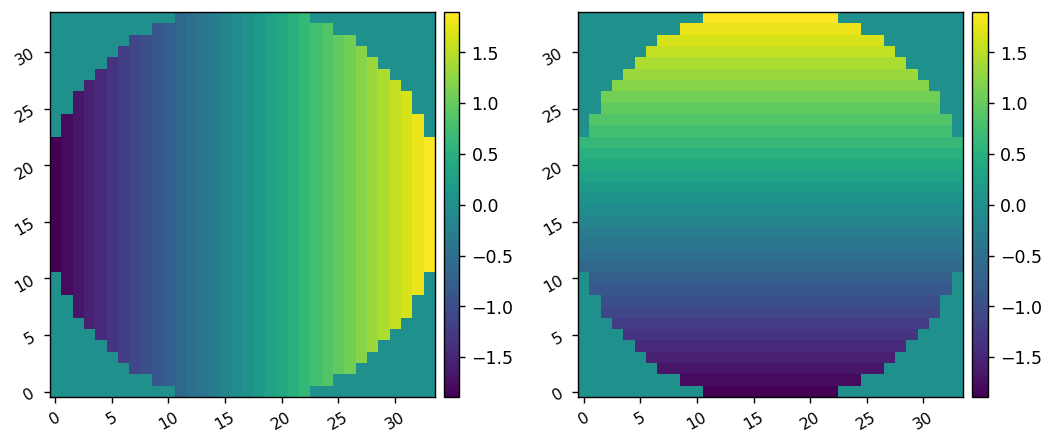

In [59]:
dm_control_modes = lina.utils.create_zernike_modes(model.dm_mask, nmodes=N_wfe_modes, remove_modes=1)
imshow2(dm_control_modes[0], dm_control_modes[1], cmap1='viridis', cmap2='viridis')

# So because the LLOWFSC and the coronagraph will be operating with different filters, I need to figure out a way to take images with two different bandpasses in the current LLOWFSC control loop. 

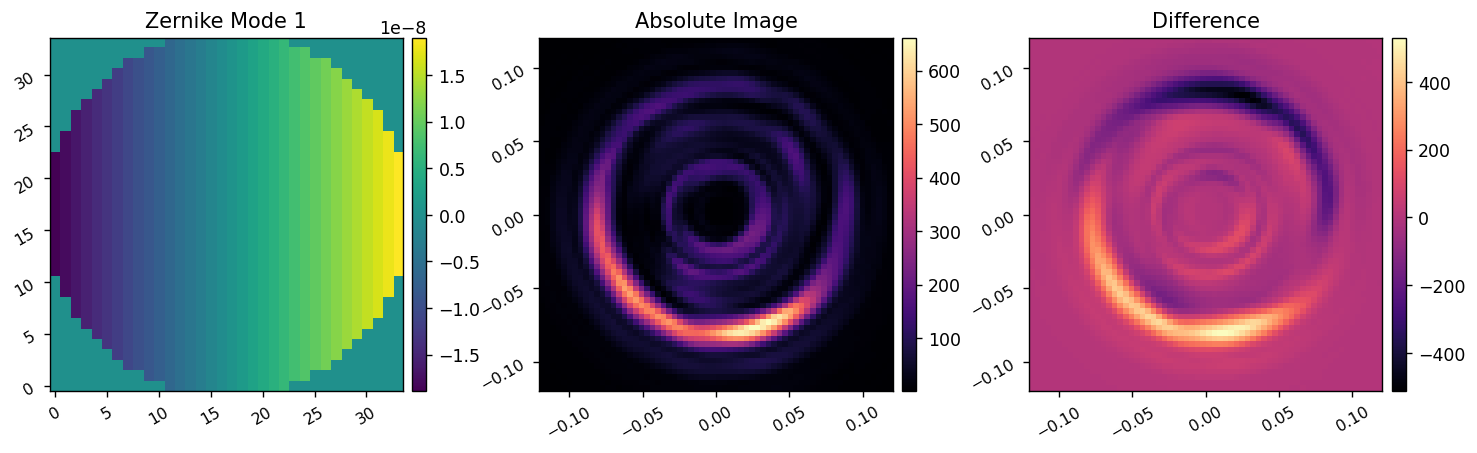

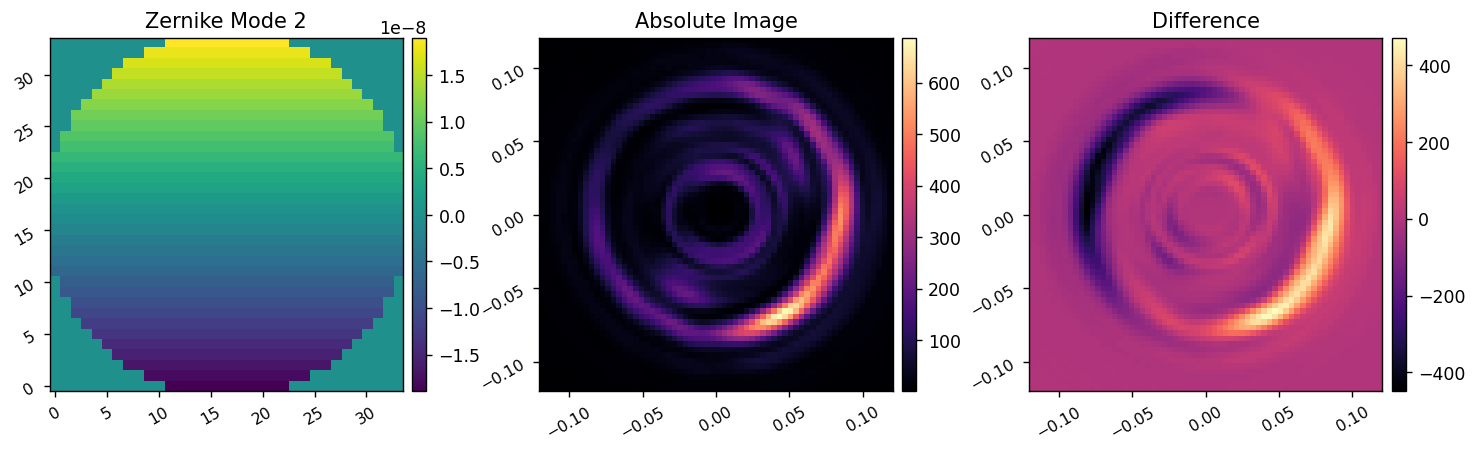

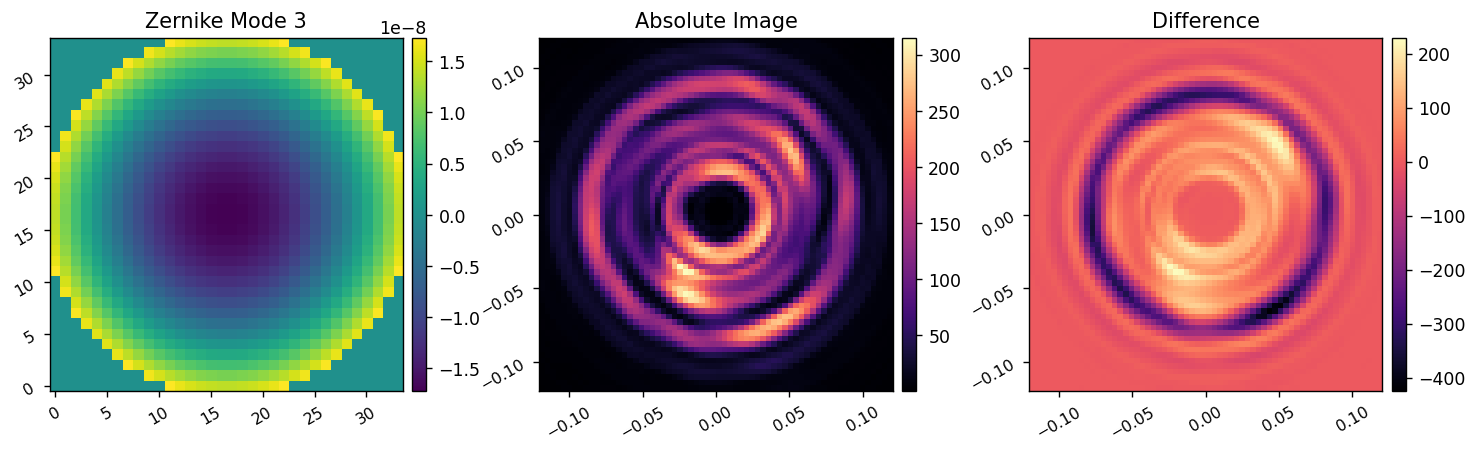

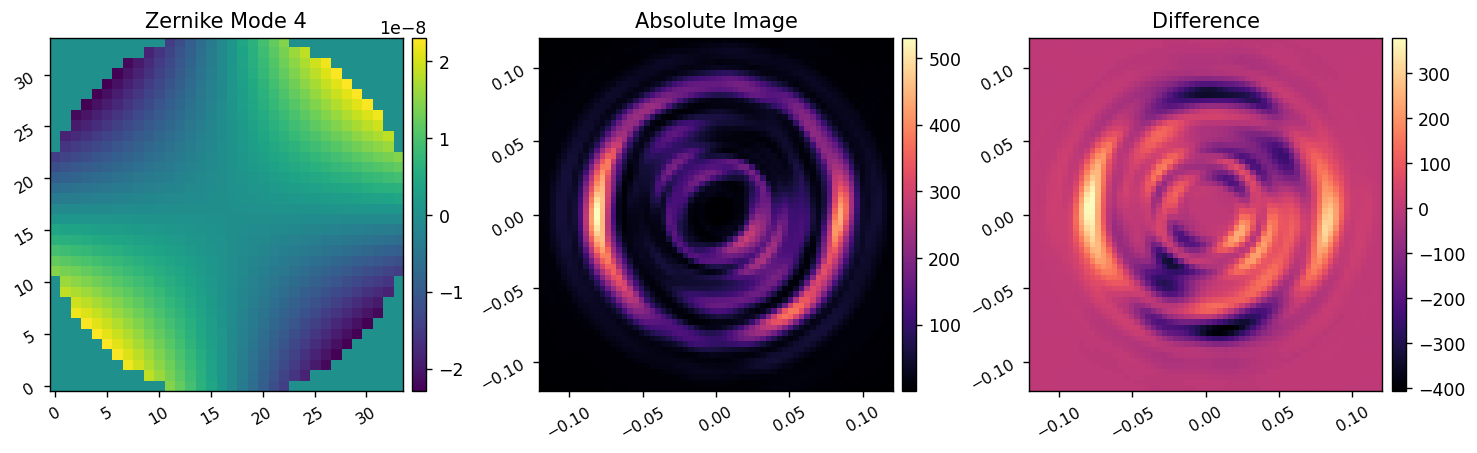

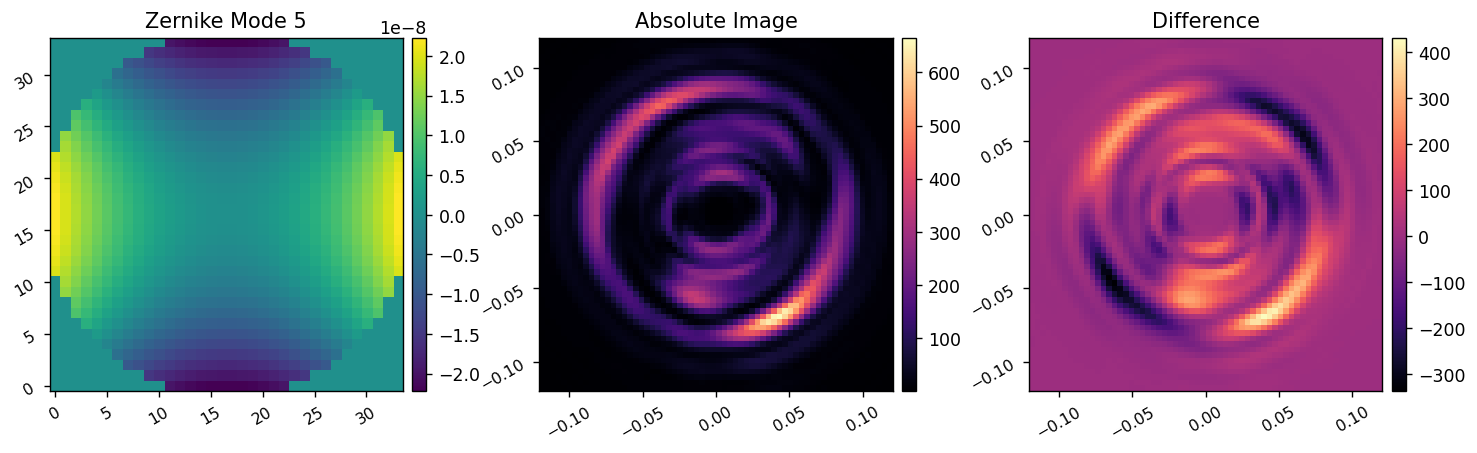

In [64]:
amp = 10e-9

model.reset_dm()

im_ref = model.snap()

responses = xp.zeros((N_wfe_modes, model.nllowfsc**2))
for i in range(N_wfe_modes):
    mode = dm_control_modes[i]

    model.set_dm(amp*mode)
    im_pos = model.snap()
    model.add_dm(-amp*mode)
    
    model.add_dm(-amp*mode)
    im_neg = model.snap()
    model.add_dm(amp*mode)

    diff = im_pos - im_neg
    responses[i] = diff.flatten()/(2*amp)

    if i < 5:
        imshow3(amp*mode, im_pos, diff, f'Zernike Mode {i+1}', 'Absolute Image', 'Difference', 
                pxscl2=model.llowfsc_pixelscale.to(u.mm/u.pix), pxscl3=model.llowfsc_pixelscale.to(u.mm/u.pix), 
                cmap1='viridis')

response_matrix = responses.T

In [65]:
U, s, Vt = xp.linalg.svd(response_matrix, full_matrices=False)
s.max()/s.min()

array(13.73305863)

In [66]:
# control_matrix = lina.utils.beta_reg(response_matrix, -10)
control_matrix = lina.utils.TikhonovInverse(response_matrix, 1e-15)

In [70]:
reload(lina)
reload(lina.llowfsc)

Nitr = 100

coro_model.reset_dm()
model.reset_dm()

coro_ims, llowfsc_ims = lina.llowfsc.run_bb_model(model, coro_model, 
                                                    WFE, 
                                                    ref_im=im_ref, 
                                                    control_matrix=control_matrix, 
                                                    control_modes=dm_control_modes,
                                                    time_series=time_series[:,:Nitr], 
                                                    zernike_modes=wfe_modes, 
                                                    control_mask=control_mask, 
                                                    return_all=True, 
                                                    # plot=True, 
                                                    )

Starting LLOWFSC control-loop simulation: delta T = 1.0000e-03s


In [21]:
0.0025*1000

2.5

Total mean contrast: 4.125e-08


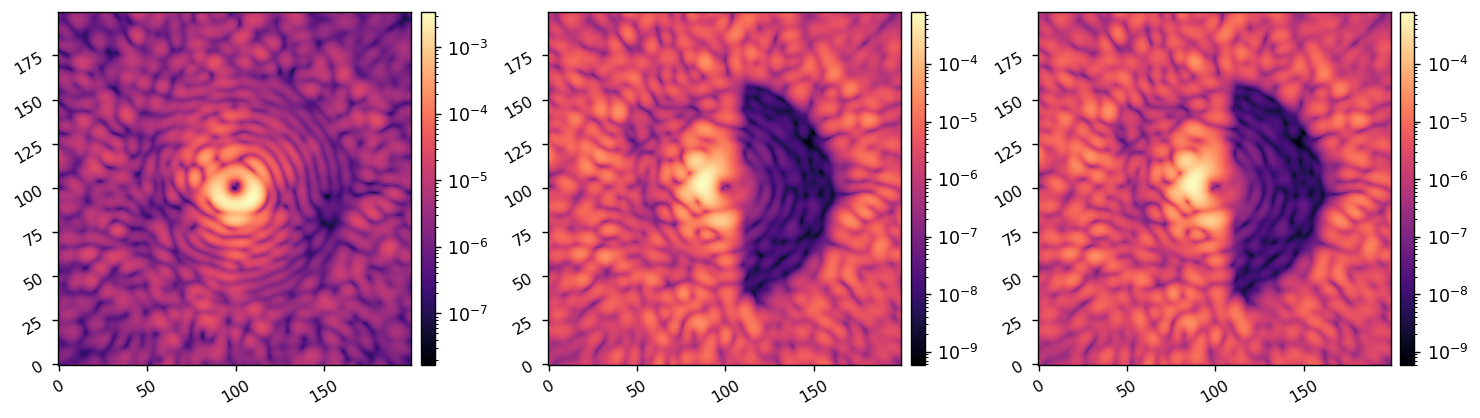

In [74]:
cind = 50

# mean_contrasts = xp.mean(coro_ims[:,control_mask], axis=1)
# total_mean_contrast = xp.mean(mean_contrasts[cind:]) # ignore the first three iterations where we have to converge to a solution first
# print(f'Total mean contrast: {total_mean_contrast:.3e}')

mean_coro_im = xp.mean(coro_ims[cind:], axis=0)
total_mean_contrast = xp.mean(mean_coro_im[control_mask]) # ignore the first three iterations where we have to converge to a solution first
print(f'Total mean contrast: {total_mean_contrast:.3e}')

diff_ims = llowfsc_ims - im_ref

imshow3(coro_ims[0], coro_ims[cind], mean_coro_im, lognorm=True)

Total mean contrast: 2.026e-08
Total mean contrast: 2.026e-08


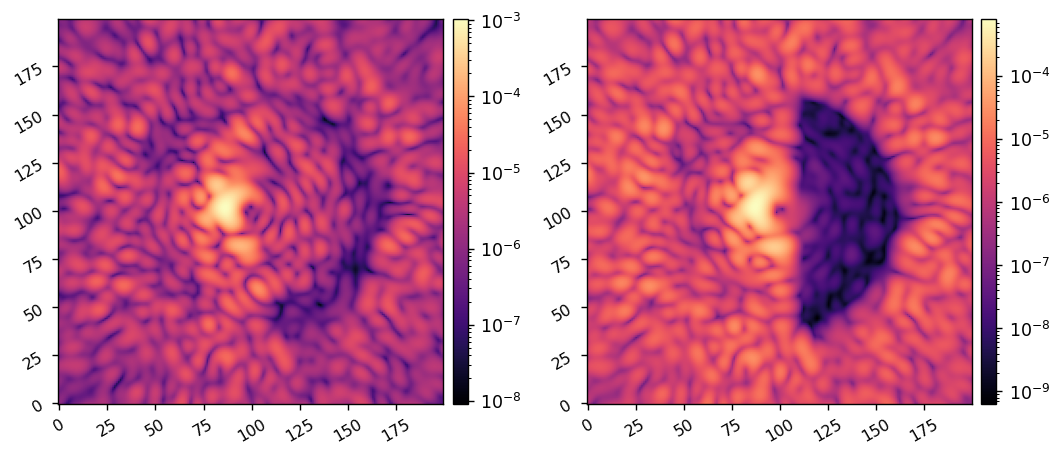

In [28]:
mean_contrasts = xp.mean(coro_ims[:,control_mask], axis=1)
total_mean_contrast = xp.mean(mean_contrasts[5:]) # ignore the first three iterations where we have to converge to a solution first
print(f'Total mean contrast: {total_mean_contrast:.3e}')

mean_coro_im = xp.mean(coro_ims[5:], axis=0)
total_mean_contrast = xp.mean(mean_coro_im[control_mask]) # ignore the first three iterations where we have to converge to a solution first
print(f'Total mean contrast: {total_mean_contrast:.3e}')

diff_ims = llowfsc_ims - im_ref

imshow2(coro_ims[0], mean_coro_im, lognorm=True)